[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moelnefary/Resting-Brain-States-WM-Performance/blob/main/notebooks/tsne_analysis.ipynb)

# Setup and Dependencies

In [ ]:
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 45.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Necessary for visualization
from nilearn import plotting, datasets

## Download & Extract Data

In [ ]:
# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!


In [ ]:
# Extract the data in `HCP_DIR`

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


# Data structures & Parameters

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquisition
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# Each experiment was repeated twice in each subject
TASK_RUNS   = ['LR','RL']

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
population = range(N_SUBJECTS)
sample_size = 10
subjects = random.sample(population, sample_size)
print(f'subjects = {subjects}')
# Randomly select 100 subjects

subjects = [326, 73, 150, 266, 262, 235, 318, 151, 291, 39]


In [ ]:
# Loading region information

dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

In [ ]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids

def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list

def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Load Data for Analysis

In [ ]:
# Load all resting-state runs (4 runs per subject)
from sklearn.preprocessing import StandardScaler

master_rest_matrix = []

HCP_DIR = "./DATA/hcp_rest"

scaler = StandardScaler()

for subject in subjects:
  subject_rest_data = []
  restrunids = get_image_ids("rest")
  #print(f'rest run ids = {restrunids}')
  for run in restrunids:
    run_data = load_single_timeseries(subject, run, dir=HCP_DIR)
    normalized_run_data = scaler.fit_transform(run_data.T)
    run_data = normalized_run_data.T
    subject_rest_data.append(run_data)
  subject_concat = np.hstack(subject_rest_data)
  master_rest_matrix.append(subject_concat)

print(f'Master rest matrix shape: {np.array(master_rest_matrix).shape}')

# Convert to numpy array (100, 360, total_timepoints_per_subject)
# Note: This will be a list of arrays if subjects have different timepoint counts
# If all subjects have same timepoints, you could stack:
# master_rest_array = np.stack(master_rest_matrix)  # Shape: (100, 360, N)

Master rest matrix shape: (10, 360, 4800)


# Sliding Window Average

In [ ]:
windowdur = 8     # (30 TRs * 0.72s/TR = ~22s)
step_size = 2
regions = 360

# Initialize master array
master_windowed_data = []

# For each row in master_rest_matrix which represents the subject's 4 runs of rest data all concetenated into one
for subject_data in master_rest_matrix:
  n_timepoints = subject_data.shape[1]
  n_windows = (n_timepoints - windowdur) // step_size +1
  # Initialize an array to store the average value of each window
  subject_windowed = np.zeros((regions, n_windows))

  for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + windowdur
    window = subject_data[:, start_idx:end_idx]
    subject_windowed[:, i] = np.mean(window, axis=1)

  master_windowed_data.append(subject_windowed)

print(f'Master windowed data shape: {np.array(master_windowed_data).shape}')
print(f'First subject windowed shape: {master_windowed_data[0].shape}')

Master windowed data shape: (10, 360, 2397)
First subject windowed shape: (360, 2397)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scaler = StandardScaler()
all_windows = np.concatenate(master_windowed_data, axis=1)  # Collapse master_windowed_data into a single line
#normalized_windows_data = scaler.fit_transform(all_windows.T)
print(f'all_windows.shape = {all_windows.shape}')

"""
# PCA
components = 60
pca = PCA(n_components=components)
pca_transformed = all_windows.T
print(f'pca_transformed.shape = {pca_transformed.shape}')
reduced_windows_data = pca.fit_transform(pca_transformed)
print(f'reduced_windows_data.shape = {reduced_windows_data.shape}')
"""

all_windows.shape = (360, 23970)


"\n# PCA\ncomponents = 60\npca = PCA(n_components=components)\npca_transformed = all_windows.T\nprint(f'pca_transformed.shape = {pca_transformed.shape}')\nreduced_windows_data = pca.fit_transform(pca_transformed)\nprint(f'reduced_windows_data.shape = {reduced_windows_data.shape}')\n"

# t-SNE

In [ ]:
# Reduce to 2D for clustering (adjust perplexity)
#all_windows = np.concatenate(master_windowed_data, axis=1)  # Shape: (360, 95500)
data_for_tsne = all_windows.T  # Shape: (95500, 360)
perplexity = 250
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=1000, metric='cosine', verbose=1)
embedding = tsne.fit_transform(data_for_tsne)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 751 nearest neighbors...
[t-SNE] Indexed 23970 samples in 0.491s...
[t-SNE] Computed neighbors for 23970 samples in 29.937s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23970
[t-SNE] Computed conditional probabilities for sample 2000 / 23970
[t-SNE] Computed conditional probabilities for sample 3000 / 23970
[t-SNE] Computed conditional probabilities for sample 4000 / 23970
[t-SNE] Computed conditional probabilities for sample 5000 / 23970
[t-SNE] Computed conditional probabilities for sample 6000 / 23970
[t-SNE] Computed conditional probabilities for sample 7000 / 23970
[t-SNE] Computed conditional probabilities for sample 8000 / 23970
[t-SNE] Computed conditional probabilities for sample 9000 / 23970
[t-SNE] Computed conditional probabilities for sample 10000 / 23970
[t-SNE] Computed conditional probabilities for sample 11000 / 23970
[t-SNE] Computed conditional probabilities for sample 12000 / 23970
[t-SNE] Computed conditional probabilities for s

# Visualization

data_for_tsne.shape = (23970, 360)
embedding.shape = (23970, 2)


'\ndid you z-score within-subject before sliding window?\n\nNormalizes the magnitudes of activations across subjects so it would better detect the general patterns vs clustering more on individual baseline differences\n'

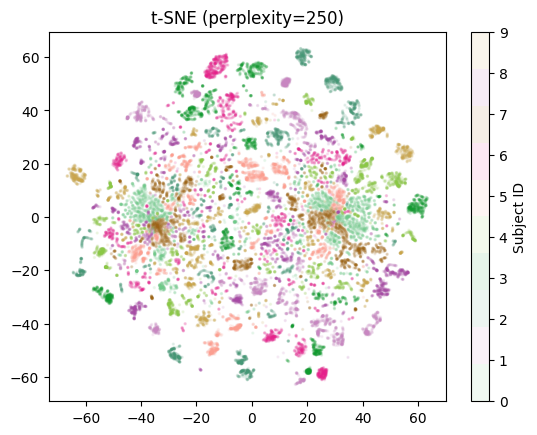

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Color by subject
cmap = ListedColormap(["#%02x%02x%02x" % (r,g,b) for r,g,b in np.random.randint(0,255,(10,3))])



#print(f'all_windows.shape = {all_windows.shape}')
print(f'data_for_tsne.shape = {data_for_tsne.shape}')
print(f'embedding.shape = {embedding.shape}')
plt.scatter(embedding[:,0], embedding[:,1], c=np.repeat(np.arange(10), 2397), cmap=cmap, s=2, alpha=0.1)
plt.colorbar(label="Subject ID")
plt.title(f"t-SNE (perplexity={perplexity})")

#plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap="viridis")
#plt.title("t-SNE Clustering of Resting-State Windows")
#plt.colorbar(label="State")
#plt.savefig("rest_states_tsne.png")

"""
did you z-score within-subject before sliding window?

Normalizes the magnitudes of activations across subjects so it would better detect the general patterns vs clustering more on individual baseline differences
"""

# Cluster & Extract States

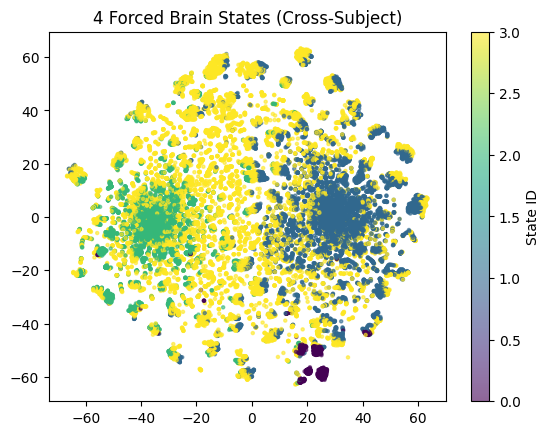

In [ ]:
# Cluster into 4 states
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(data_for_tsne)  # Or use embedding

# Get state centroids (your "brain state vectors")
state_vectors = kmeans.cluster_centers_  # Shape: (4, 360)

plt.scatter(embedding[:,0], embedding[:,1],
            c=cluster_labels,
            cmap='viridis',
            s=5,
            alpha=0.6)
plt.title("4 Forced Brain States (Cross-Subject)")
plt.colorbar(label="State ID")


# Save states
np.save("resting_state_vectors.npy", state_vectors)

In [ ]:
# Compare state distribution across subjects
state_counts = []
for subj in range(10):
    counts = np.bincount(cluster_labels[subj*955:(subj+1)*955], minlength=4)
    state_counts.append(counts)
print("State frequencies:\n", np.array(state_counts))

# Get the functional connectivity pattern for each state
state_centroids = []
for state in range(4):
    mask = (cluster_labels == state)
    centroid = np.mean(all_windows[:, mask], axis=1)  # (360,)
    print(f'centroid.shape for state {state} = {centroid.shape}')
    print(f'centroid for {state}= {centroid}')
    state_centroids.append(centroid)

state_centroids = np.array(state_centroids)
print(f'state_centroids.shape = {state_centroids.shape}')
np.savetxt("madison-t-SNE-brainstates", state_centroids)

State frequencies:
 [[  0 340 312 303]
 [  0 355 248 352]
 [  8 344 133 470]
 [104 144 130 577]
 [  3 297 106 549]
 [  1 182 147 625]
 [  6 238 109 602]
 [  0 253  45 657]
 [ 97 139  78 641]
 [120 239 186 410]]
centroid.shape for state 0 = (360,)
centroid for 0= [ 0.61381698 -0.04025547  0.33425415  0.66363306  0.46996524  0.20933079
  0.45484929  0.89228128 -0.08323464  0.11117256  0.78902272  0.31968428
  0.35394215  0.38603089 -0.01637274  0.41273583  0.11514587 -0.3717976
  0.24428674  0.21640954  0.0604176  -0.04639676  0.16674271 -0.2268972
  0.30806787  0.28005845 -0.0605461   0.26559169 -0.15093158 -0.31094576
  0.41427671  1.25608044  0.20697176  0.48638784  0.16324967  0.58174658
  0.6830975   1.19037832  0.34840481  1.10637176  1.18246398  0.10935929
  0.79819166  0.60035421 -0.02040225 -0.10183254 -0.03271999 -0.02762517
 -0.03712923 -0.20517195  0.76747441  0.17866263  0.63427826 -0.02191158
  0.32769595  0.36195487  1.27316754  1.18829832  1.12673012  1.15157793
 -1.55708